In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pnd
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import pydotplus

In [3]:
path = "C:/Users/Diego/PycharmProjects/MD/"

carreras = pnd.read_excel(path + "carreras2017.xlsx")
empleabilidad = pnd.read_excel(path + "empleabilidadingresos2017.xlsx")

new_names_empleabilidad = empleabilidad.columns.values
new_names_carreras = carreras.columns.values
new_names_empleabilidad[1] = 'Nombre institución'

for i in range(len(new_names_empleabilidad)):
    new_names_empleabilidad[i] = new_names_empleabilidad[i].strip().lower().replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n")
for i in range(len(new_names_carreras)):
    new_names_carreras[i] = new_names_carreras[i].strip().lower().replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n")
    
empleabilidad.columns = new_names_empleabilidad
carreras.columns = new_names_carreras

carreras['nombre_institucion'] = carreras['nombre_institucion'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())
carreras['nombre_carrera'] = carreras['nombre_carrera'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())

carreras['id'] = carreras['nombre_institucion'] + '-' + carreras['nombre_carrera']

# Quitar espacios y tildes, dejar todo en mayúscula
empleabilidad['nombre_institucion'] = empleabilidad['nombre_institucion'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())
empleabilidad['nombre_carrera'] = empleabilidad['nombre_carrera'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())

empleabilidad['id'] = empleabilidad['nombre_institucion'] + '-' + empleabilidad['nombre_carrera']

In [4]:
print("Atributos empleabilidad:\n",empleabilidad.keys())
print("Atributos carreras:\n", carreras.keys())

print(len(carreras['id'].unique()))
print(len(empleabilidad['id'].unique()))

print(carreras['promedio_psu_2016_de_matricula_1er_ano_2016'].dtype)

Atributos empleabilidad:
 Index(['tipo_de_institucion', 'nombre_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       'nombre_carrera', '%_alumnos_de_establecimientos_subvencionados',
       'retencion_1er_ano', 'duracion_real_(semestres)',
       'empleabilidad_al_1er_ano', 'ingreso_promedio_al_4°_ano_de_titulacion',
       'nombre_carrera_generica', 'ingreso_promedio_al_4°_ano', 'id'],
      dtype='object')
Atributos carreras:
 Index(['nombre_institucion', 'nombre_carrera', 'arancel_anual_2017',
       'costo_de_titulacion', 'duracion_formal', 'nivel_carrera',
       'matricula_1er_ano__femenina_2016', 'matricula_1er_ano_masculina_2016',
       'matricula_1er_ano_2016', 'municipal', 'particular_subvencionado',
       'particular_pagado', 'titulacion_femenina_2015',
       'titlacion_masculna_2015', 'titulacion_total_2015',
       'promedio_psu_2016_de_matricula_1er_ano_2016',
       'promedio_nem_2016_de_matricula_2016', 'id'],
      

In [5]:
filtrado = carreras[carreras['matricula_1er_ano_2016'] > 0]
filtrado = filtrado.fillna(0)

filtrado_empleabilidad = empleabilidad[empleabilidad['ingreso_promedio_al_4°_ano'] > 0]
filtrado_empleabilidad = filtrado_empleabilidad.fillna(0)

del filtrado['nombre_carrera']
del filtrado['nombre_institucion']
del filtrado_empleabilidad['nombre_carrera']
del filtrado_empleabilidad['nombre_institucion']

def acreditacion(valor):
    if valor == 'No':
        return 0
    return int(valor[0])

def sueldos(valor):
    if 0 <= valor <= 650000:
        return 0
    elif 650000 < valor <= 950000:
        return 1
    elif 950000 < valor <= 1250000:
        return 2
    elif 1250000 < valor <= 1550000:
        return 3
    elif 1550000 < valor <= 1850000:
        return 4
    elif 1850000 < valor <= 2150000:
        return 5
    else:
        return 6

filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'] = \
filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'].apply(acreditacion)
filtrado_empleabilidad['ingreso_promedio_al_4°_ano'] = filtrado_empleabilidad['ingreso_promedio_al_4°_ano'].apply(sueldos)

filtrado_c = filtrado.copy()
filtrado_empleabilidad_c = filtrado_empleabilidad.copy()

llaves = filtrado.keys()
for j in range(len(llaves)):
    if filtrado[llaves[j]].dtype == 'int64' or filtrado[llaves[j]].dtype == 'float64':
        continue
    if llaves[j] in ['id']:
        continue
    values = filtrado[llaves[j]].unique()
    dic = {}
    for i in range(len(values)):
        dic[values[i]] = i

    filtrado[llaves[j]] = filtrado[llaves[j]].apply(lambda x: dic[x])
    
llaves = filtrado_empleabilidad.keys()
for j in range(len(llaves)):
    if filtrado_empleabilidad[llaves[j]].dtype == 'int64' or filtrado_empleabilidad[llaves[j]].dtype == 'float64':
        continue
    if llaves[j] in ['id']:
        continue
    values = filtrado_empleabilidad[llaves[j]].unique()
    dic = {}
    for i in range(len(values)):
        dic[values[i]] = i

    filtrado_empleabilidad[llaves[j]] = filtrado_empleabilidad[llaves[j]].apply(lambda x: dic[x])
    
# empleabilidad: acreditacion, tipo, area, del %weas, 

agrupado = filtrado.groupby(['id'])
final = agrupado.agg({'arancel_anual_2017' : np.mean,
                      'costo_de_titulacion' : np.mean,
                      'duracion_formal' : np.mean,
                      'matricula_1er_ano__femenina_2016' : np.sum,
                      'matricula_1er_ano_masculina_2016' : np.sum,
                      'matricula_1er_ano_2016' : np.sum,
                      'titulacion_femenina_2015' : np.sum,
                      'titlacion_masculna_2015' : np.sum,
                      'titulacion_total_2015' : np.sum,
                      'municipal' : np.mean,
                      'particular_subvencionado' : np.mean,
                      'particular_pagado' : np.mean,
                      'promedio_psu_2016_de_matricula_1er_ano_2016' : np.mean,
                      'promedio_nem_2016_de_matricula_2016' : np.mean,
                      'nivel_carrera' : np.mean
                     }).reset_index()
print(len(filtrado['id'].unique()))
print(len(final))

2891
2891


In [6]:
filtrado_c.to_excel("filtrado_carreras.xlsx")
filtrado_empleabilidad_c.to_excel("filtrado_empleabilidad.xlsx")

fusion_c = pnd.merge(filtrado_empleabilidad_c, filtrado_c, on='id', how='inner')

fusion_c.to_excel("filtrado_fusion.xlsx")

In [7]:
print(final['nivel_carrera'].unique())
print(filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'].unique())

[1 0]
[3 0 6 4 5 7 2]


In [8]:
fusion = pnd.merge(filtrado_empleabilidad, filtrado, on='id', how='inner')

ag = fusion.groupby(['id'])
ds = ag.first().copy()
print(ds.keys())

y = ds['ingreso_promedio_al_4°_ano']
del ds['ingreso_promedio_al_4°_ano']
X = ds


Index(['tipo_de_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       '%_alumnos_de_establecimientos_subvencionados', 'retencion_1er_ano',
       'duracion_real_(semestres)', 'empleabilidad_al_1er_ano',
       'ingreso_promedio_al_4°_ano_de_titulacion', 'nombre_carrera_generica',
       'ingreso_promedio_al_4°_ano', 'arancel_anual_2017',
       'costo_de_titulacion', 'duracion_formal', 'nivel_carrera',
       'matricula_1er_ano__femenina_2016', 'matricula_1er_ano_masculina_2016',
       'matricula_1er_ano_2016', 'municipal', 'particular_subvencionado',
       'particular_pagado', 'titulacion_femenina_2015',
       'titlacion_masculna_2015', 'titulacion_total_2015',
       'promedio_psu_2016_de_matricula_1er_ano_2016',
       'promedio_nem_2016_de_matricula_2016'],
      dtype='object')


In [9]:
clf = tree.DecisionTreeClassifier()

cross_val_score(clf, X, y, cv=5)

array([ 0.96052632,  0.96688742,  0.98      ,  0.98630137,  0.95862069])

In [12]:
clf = clf.fit(X, y)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('tree.png')

True

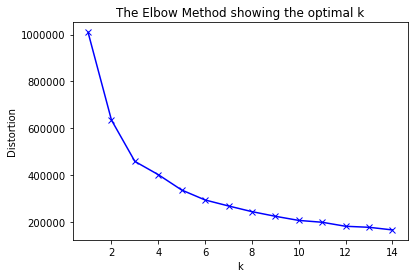

In [20]:
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
km = KMeans(n_clusters=3).fit(X)
